In [172]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image
#Clear output
from IPython.display import clear_output

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

trainDataset = torchvision.datasets.FashionMNIST("fashionDataset", train=True, download=True, transform=transforms.ToTensor())
testDataset = torchvision.datasets.FashionMNIST("fashionTrain", train=False, download=True, transform=transforms.ToTensor())

cuda


In [173]:
mapping = trainDataset.targets == 9

trousers = trainDataset.data[mapping]
trousers = trousers.unsqueeze(1)
trousers = trousers.float()
trousers.shape


torch.Size([6000, 1, 28, 28])

In [174]:
BATCH_SIZE = 1000
EPOCHS = 50
LEARNING_RATE = 0.00005
alphaG = 0.005
alphaD = 0.00002

dataloader = DataLoader(trousers, batch_size=BATCH_SIZE, shuffle=True)

In [175]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 50, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2, 2)
        )
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(50*3*3, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 2)
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.reshape(-1, 50*3*3)
        x = self.fc1(x)
        return x
    
class Generator(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = torch.nn.Sequential(
            torch.nn.Linear(10, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 784),
        )

    def forward(self, x):
        x = self.fc1(x)
        x = x.reshape(-1, 1, 28, 28)
        return x
    
# noise = torch.randn(5, 10)
# noise = noise.to(device)
# generator = Generator()
# generator = generator.to(device)
# fake= generator(noise)

# discriminator = Discriminator()
# discriminator = discriminator.to(device)
# pred = discriminator(fake)
# pred


In [176]:
loss_discriminator = torch.nn.CrossEntropyLoss()

discriminator = Discriminator().to(device)
generator = Generator().to(device)

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=alphaD)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=alphaG)

In [177]:
#Print number of params
print("Generator params: ", sum(p.numel() for p in generator.parameters() if p.requires_grad))
print("Discriminator params: ", sum(p.numel() for p in discriminator.parameters() if p.requires_grad))

Generator params:  100484
Discriminator params:  98344


In [178]:
for epoch in range(EPOCHS):

    lossOfDiscriminator = 0
    lossOfGenerator = 0

    while True:
        avgLoss = 0
        for i, realImage in enumerate(dataloader):
            optimizer_discriminator.zero_grad()
            realImage = realImage.to(device)

            realLabel = torch.eye(2)[0].repeat(BATCH_SIZE, 1).to(device)
            fakeLabel = torch.eye(2)[1].repeat(BATCH_SIZE, 1).to(device)

            noise = torch.randn(BATCH_SIZE, 10).to(device)
            fakeImage = generator(noise)

            pred_real = discriminator(realImage)
            pred_fake = discriminator(fakeImage)

            loss_real = loss_discriminator(pred_real, realLabel)
            loss_fake = loss_discriminator(pred_fake, fakeLabel)
            loss = loss_real + loss_fake
            loss.backward()
            optimizer_discriminator.step()
            lossOfDiscriminator += loss.item()
            avgLoss += loss.item()
        if avgLoss/len(dataloader) < 0.1:
            break

            # if i % 5 == 0:
            #     print("Loss: ", loss.item())

    
    while True:
        avgLoss = 0
        for i, realImage in enumerate(dataloader):
            optimizer_generator.zero_grad()
            realImage = realImage.to(device)

            faketargets = torch.eye(2)[0].repeat(BATCH_SIZE, 1).to(device)
            realtargets = torch.eye(2)[1].repeat(BATCH_SIZE, 1).to(device)

            noise = torch.randn(BATCH_SIZE, 10).to(device)
            fakeImage = generator(noise)

            pred_fake = discriminator(fakeImage)
            pred_real = discriminator(realImage)

            fake_loss = loss_discriminator(pred_fake, faketargets)

            loss = fake_loss
            loss.backward()
            optimizer_generator.step()
            lossOfGenerator += loss.item()
            avgLoss += loss.item()
        #print("Loss of generator: ", avgLoss/len(dataloader))
        if avgLoss/len(dataloader) < 0.01:
            break

        # if i % 5 == 0:
        #     print("Loss: ", loss.item())
    print("Epoch:",epoch)
    print("Loss of discriminator: ", lossOfDiscriminator/len(dataloader))
    print("Loss of generator: ", lossOfGenerator/len(dataloader))


    noise = torch.randn(1, 10).to(device)
    fakeImage = generator(noise)

    y_pred = discriminator(fakeImage)
    y_pred = torch.softmax(y_pred, dim=1)

    #Show generator output

    fakeImage = fakeImage.reshape(28, 28)
    fakeImage = fakeImage.detach().cpu().numpy()
    plt.imshow(fakeImage, cmap='gray')
    plt.show()

    #Show real image

    realImage = trousers[0]
    realImage = realImage.reshape(28, 28)
    plt.imshow(realImage, cmap='gray')
    plt.show()

    clear_output(wait=True)

    

KeyboardInterrupt: 

In [ ]:
#Test

noise = torch.randn(1, 10).to(device)
fakeImage = generator(noise)

y_pred = discriminator(fakeImage)
y_pred = torch.softmax(y_pred, dim=1)

print(y_pred)

tensor([[9.9937e-01, 6.3420e-04]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


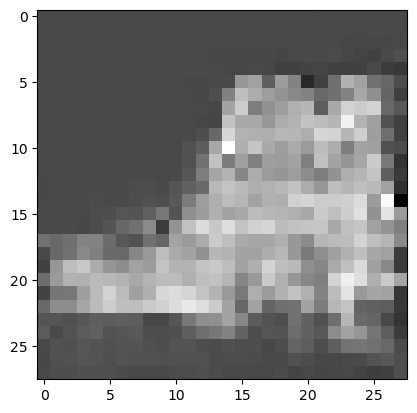

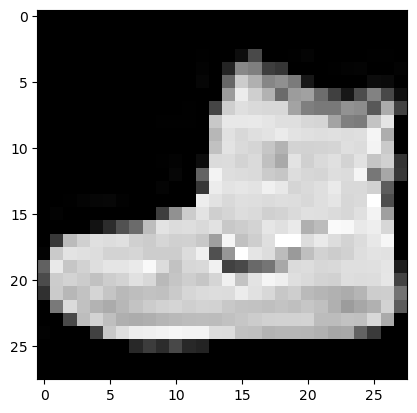

In [ ]:
#Show generator output

fakeImage = fakeImage.reshape(28, 28)
fakeImage = fakeImage.detach().cpu().numpy()
plt.imshow(fakeImage, cmap='gray')
plt.show()

#Show real image

realImage = trousers[0]
realImage = realImage.reshape(28, 28)
plt.imshow(realImage, cmap='gray')
plt.show()

In [ ]:
saving = False
if saving:
    torch.save(generator.state_dict(), "generatorA.pt")
    torch.save(discriminator.state_dict(), "discriminatorA.pt")

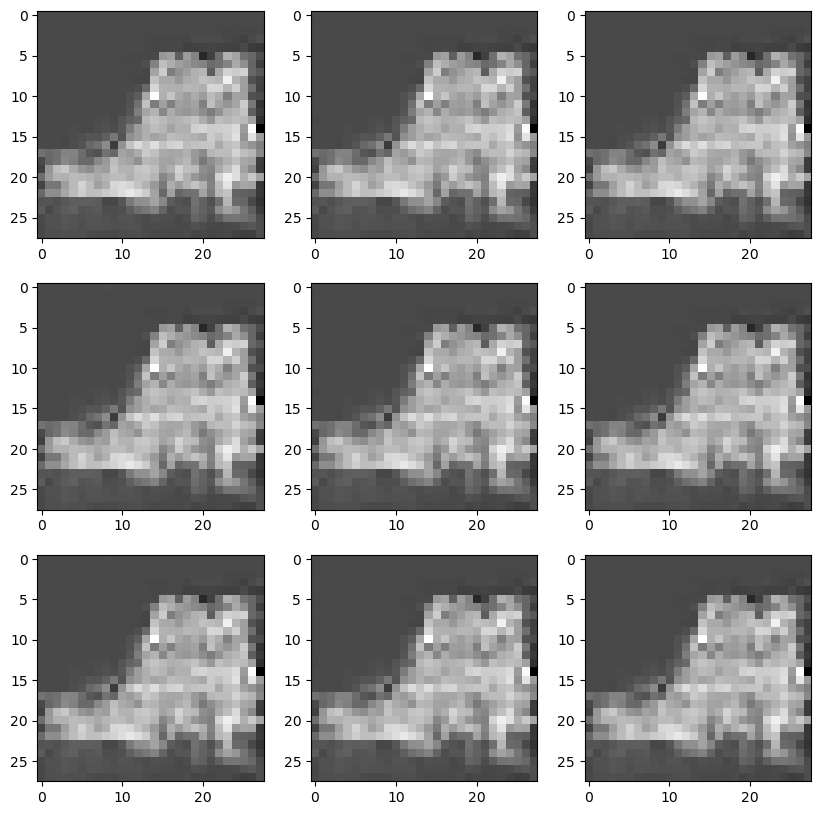

In [ ]:
#Show grid of generated images

noise = torch.randn(9, 10).to(device)
fakeImage = generator(noise)

fakeImage = fakeImage.reshape(9, 28, 28)
fakeImage = fakeImage.detach().cpu().numpy()

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for i in range(3):
    for j in range(3):
        ax[i, j].imshow(fakeImage[i*3+j], cmap='gray')